In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

In [3]:
class vAE(nn.Module):
    def __init__(self):
        super(vAE,self).__init__()

        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, 20)
        self.fc22 = nn.Linear(400, 20)
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, 784)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparametrize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        eps = Variable(torch.FloatTensor(std.size()).normal_())
        return eps.mul(std).add_(mu)

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return F.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparametrize(mu, logvar)
        return self.decode(z), mu, logvar

In [4]:
transform = transforms.Compose([transforms.ToTensor()])
trainset = torchvision.datasets.MNIST(root = './', train = True, download = True,transform = transform)
testset = torchvision.datasets.MNIST(root = './', train = False, download = True,transform = transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size = 64, shuffle = True)
test_loader = torch.utils.data.DataLoader(testset, batch_size = 64, shuffle = False)

In [5]:
# init the network
ae = vAE()
print(ae)

vAE(
  (fc1): Linear(in_features=784, out_features=400, bias=True)
  (fc21): Linear(in_features=400, out_features=20, bias=True)
  (fc22): Linear(in_features=400, out_features=20, bias=True)
  (fc3): Linear(in_features=20, out_features=400, bias=True)
  (fc4): Linear(in_features=400, out_features=784, bias=True)
)


In [6]:
#init optimizer
optimizer = optim.SGD(ae.parameters(), lr = 0.001)
# init loss function
criterion = nn.BCELoss()
print(criterion)
print(optimizer)

BCELoss()
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.001
    momentum: 0
    nesterov: False
    weight_decay: 0
)


In [7]:
def loss_function(new_x, x, mu, logvar):
    BCE = criterion(new_x, x)
    KLD_element = mu.pow(2).add_(logvar.exp()).mul_(-1).add_(1).add_(logvar)
    KLD = torch.sum(KLD_element).mul_(-0.5)
    # KL divergence
    return BCE + KLD

In [8]:
epochs = 10
loss_list = []
predictions_list = []
for epoch in range(0,epochs):
    ae.train()
    train_loss = 0
    # to get the latest predictions for sake of report only
    predictions = []
    for batchId, (data,_) in enumerate(train_loader):
        data  = Variable(data)
        data = data.view(data.size(0),-1)
        # gradient is set to 0
        optimizer.zero_grad()
        # passing through the network
        net_out, mu, logvar = ae(data)
        # calculaing loss
        loss = loss_function(net_out, data, mu, logvar)
        # propogating loss at current step
        loss.backward()
        # updating parameters (in steps) after gradient descent
        optimizer.step()
        # calculate total loss
        train_loss += loss
        # predictions
        predictions.append(net_out)
        predictions_list.append(net_out)
    loss_list.append(train_loss)
    print('Epoch: {} Average loss: {:.4f}'.format(
        epoch, train_loss / len(train_loader.dataset)))

/Users/deadsenses/myenv/lib/python3.7/site-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch: 0 Average loss: 0.0168
Epoch: 1 Average loss: 0.0116
Epoch: 2 Average loss: 0.0111
Epoch: 3 Average loss: 0.0109
Epoch: 4 Average loss: 0.0108
Epoch: 5 Average loss: 0.0107
Epoch: 6 Average loss: 0.0106
Epoch: 7 Average loss: 0.0105
Epoch: 8 Average loss: 0.0105
Epoch: 9 Average loss: 0.0104


In [9]:
torch.save(ae, "hw5_vae.pth")

/Users/deadsenses/myenv/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type vAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/Users/deadsenses/myenv/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Linear. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


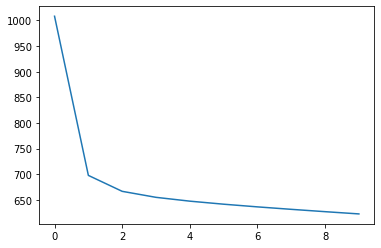

In [10]:
plt.plot(loss_list)
plt.savefig(fname='vae.png',format='png')

In [117]:
# figure = plt.figure()
# num_of_images = 16
# images = []
# for i in predictions:
#     images.append(i.view(i.size(0), 1, 28, 28))
# # images = predictions.view(predictions.size(0), 1, 28, 28)
# # _, axes = plt.subplots(1,2)
# for index in range(0, num_of_images):
#     plt.subplot(4, 4, index+1)
#     plt.imshow(np.moveaxis(images[index].detach().numpy().squeeze(), 0, -1), cmap='gray_r')
#     plt.axis('off')
#     plt.savefig(fname='vae_{}.png'.format(index),format='png')

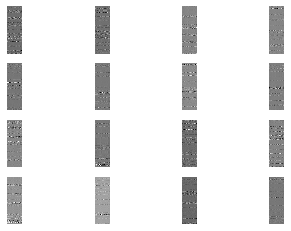

In [19]:
figure = plt.figure()
num_of_images = 16
index = 0
for batchId, (data,_) in enumerate(test_loader):
    index += 1
    data  = Variable(data)
    data = data.view(data.size(0),-1)
    res = ae(data)
    plt.subplot(4, 4, index)
    plt.imshow(res[1].detach().numpy().squeeze(), cmap='gray_r')
    plt.axis('off')
    if index == 16:
        break

# _, axes = plt.subplots(1,2)
